In [4]:
using Distributions 
using PyPlot

#### Generate data 
Generate toy-data that has location information .
k signal clusters along a 2 dimensional  
n by n grid 


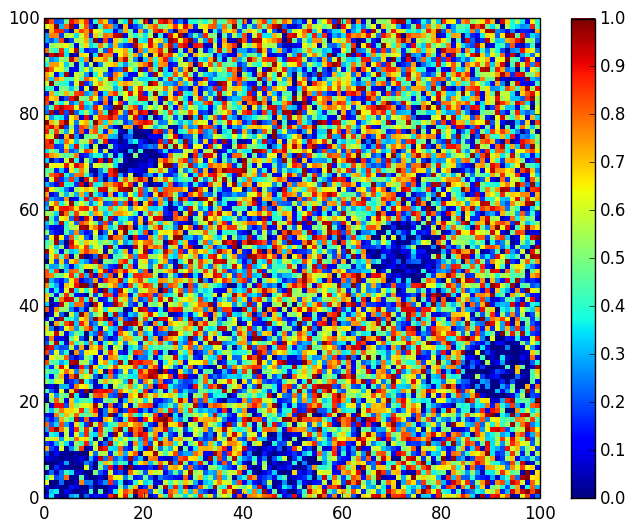

PyObject <matplotlib.colorbar.Colorbar instance at 0x32731d050>

In [154]:
#k clusters of signals, the rest are all null   

#point = (xloc, yloc, p-value)
n = 100; 
k = 5; 

null_dist = Uniform(0,1);
dataSet = zeros(n,n);

#generate k centers randomly
center_vec = Tuple{Int,Int}[]
for(i in 1:k)
    center = (rand(DiscreteUniform(1,n)), rand(DiscreteUniform(1,n)));
    while(center in center_vec) center = (rand(DiscreteUniform(1,n)), rand(DiscreteUniform(1,n))); end
    push!(center_vec, center); 
end

#generate k Beta distributions randomly 
betas = Float64[];
#alpha = 1/beta so only need to store one parameter
for(i in 1:k)
    #really light signals
    #push!(betas, 2)
    push!(betas, rand(Uniform(2,5)))
end



#given the center of a cluster 
#returns the points associated with the circle 
#right now ignores end point of grid. 
function getCluster(center, n, radius)
    x0 = center[1];
    y0 = center[2];   
    cluster = Tuple{Int,Int}[];
    for(y in -radius:radius)
        for(x in -radius:radius)
            if(x*x + y*y <= radius*radius)
                push!(cluster, (x0 + x, y0 + y))
            end
        end
    end
    return cluster; 
end
    

#generate k clusters with randomly generated radius 
cluster_arr = Array{Tuple{Int,Int},1}[];
for(i in 1:k)
    radius = round(rand(TruncatedNormal(7,2,5,10)));
   # radius = round(n/8);
    push!(cluster_arr, getCluster(center_vec[i], n, radius))
end


#generate dataset
for(i in 1:n)
    for(j in 1:n)
        is_null = true;
        for(z in 1:k)
            cluster = cluster_arr[z];
            beta = betas[z];
            beta_dist = Beta(1/beta,beta);
            if((i,j) in cluster)
                is_null = false; 
                dataSet[i,j] = rand(beta_dist);
            end
        end
        if(is_null) dataSet[i,j] = rand(null_dist); end
    end
end
pcolormesh(dataSet)
colorbar()



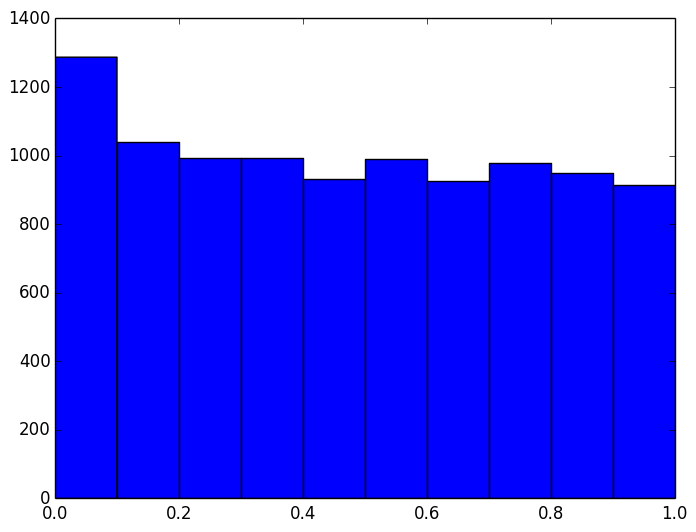

([1287.0,1039.0,993.0,993.0,932.0,989.0,925.0,979.0,948.0,915.0],[5.1983344535683944e-12,0.09998343132356269,0.19996686264192706,0.29995029396029144,0.3999337252786558,0.49991715659702013,0.5999005879153845,0.6998840192337488,0.7998674505521132,0.8998508818704776,0.9998343131888419],Any[PyObject <matplotlib.patches.Rectangle object at 0x3241eabd0>,PyObject <matplotlib.patches.Rectangle object at 0x3269f9d50>,PyObject <matplotlib.patches.Rectangle object at 0x324431450>,PyObject <matplotlib.patches.Rectangle object at 0x32418b810>,PyObject <matplotlib.patches.Rectangle object at 0x3269eef50>,PyObject <matplotlib.patches.Rectangle object at 0x324373750>,PyObject <matplotlib.patches.Rectangle object at 0x324118d50>,PyObject <matplotlib.patches.Rectangle object at 0x324118b90>,PyObject <matplotlib.patches.Rectangle object at 0x324118750>,PyObject <matplotlib.patches.Rectangle object at 0x3222afe90>])

In [171]:
data = reshape(dataSet,n*n) #reshapes along column 
locations = Tuple{Int,Int}[]; 
for(i in 1:n)
    for(j in 1:n)
        push!(locations, (j,i))
    end
end
#verify that it did the right thing 
for(z in 1:(n*n))
    loc = locations[z];
    x = loc[1];
    y = loc[2]; 
   if(dataSet[x,y] != data[z])
        println(x,y)
    end
end
plt[:hist](data)


Similar algorithm to Stephens paper 
Assume data is generated according to a mixture model which incorporates location information. 


1. Sample number of signal clusters and labels by running birth-death process

2. Sample betas of signal clusters with everything else fixed 






Initialize parameters and prior distributions:

In [172]:
##### initialize parameters and prior distributions 
#prior distributions on parameters

#prior distribution on beta
mu = 8; 
sigma = 5; 
Beta_priordist = TruncatedNormal(mu, sigma, 2, 200);

#prior distribution on number of signal clusters
Clusters_priordist = Truncated(Poisson(50), 1, 500)

#initial number of clusters
num_clusters = 2; #number of signal clusters

#prior distribution on labels (bit more complicated than this when we incorporate location info)
#labels_prior = DiscreteUniform(1,num_clusters);


#initialize rest of parameters
labels = ones(length(data)); 

#to do put better prior on radius 
radius_prior = TruncatedNormal(5, 2, 1,100); 

#store clusters and their radiuses in vector
array_of_clusters = Array{Tuple{Int64,Int64},1}[];  
array_of_radius = Float64[]; 


for(i in 1:num_clusters)
    radius = round(rand(radius_prior)); 
    point = rand(DiscreteUniform(1,length(data)));
    center = locations[point]; 
    newCluster = getCluster(center, n, radius);
    for(point in newCluster)
        index = find(locations .== point);
        labels[index] = i+1; #since label 1 is the null label this new label
    end
    push!(array_of_radius, radius);
    push!(array_of_clusters, newCluster);
end


#store the clusters in a vector 


#add null cluster to beginning 
b_arr = [1]; 
b_arr = [b_arr; rand(Beta_priordist,num_clusters)]; #beta distribution parameters




3-element Array{Float64,1}:
 1.0    
 8.83234
 2.85806

Run birth-death process to get cluster labels. 

In [173]:
#birth death-chain to sample labels 


#birth rate 
lambda =10; 
birth_rate = lambda;
curr_time = 0; 
t_0 = 1000; 

##keep last K labels 
K = 100; 

label_arr = zeros(length(data), K); 

#distribution of signal betas
bcurr_arr = b_arr[2:end];
for(idx_1 in 1:10000)
    while(curr_time < t_0)
       # if(length(labels > length(data))) break; end;
        delta_arr = zeros(num_clusters);
        #append null 
        b_dist = [Beta(1/b,b) for b in [1; bcurr_arr]];

        #calculate log-likelihood of current model
        l_y = 0; 
        for(idx_2 in 1:(num_clusters+1))
            cluster = data[labels .== idx_2];
            if(length(cluster) > 0) #shouldn't need this actually
                l_y = l_y + loglikelihood(b_dist[idx_2], cluster);
            end
        end
        c_y = loglikelihood(Clusters_priordist, [num_clusters]);

        #calculate death rate of component j
        for(idx_3 in 1:num_clusters)
            b_arr_death = copy(bcurr_arr);
            label_death = deepcopy(labels);
            deleteat!(b_arr_death, idx_3);
            label_death[labels.== idx_3+1] = 1; #turn those labels back to signals 

            #calculate log likelihood after death
            ldy = 0; 
            for(idx_4 in 1:(num_clusters+1))
                cluster = data[label_death .== idx_4];
                if(length(cluster) > 0)
                    ldy = ldy + loglikelihood(b_dist[idx_4], cluster);
                end
            end 
            c_yd = loglikelihood(Clusters_priordist, [num_clusters-1]);
            delta_arr[idx_3] = log(lambda) + (ldy - l_y) + (c_yd - log(num_clusters) - c_y); 
        end
        death_rate = sum(exp(delta_arr)); 

        #simulate time to next birth/death from an exponential distribution 
        #with mean: birth_rate + death_rate
        t = 1/rand(Exponential(birth_rate + exp(death_rate)));
        curr_time = curr_time + t; 
        if(curr_time < t_0) #then we have a birth or a death 
            #flip a weighted coin to determine birth or death 
            is_birth = rand(Bernoulli(birth_rate/(birth_rate + death_rate)));
            if(is_birth == 1)#we have a birth 
                #TO DO PUT MORE INFORMATIVE PRIOR AT POINT 
                #THE BIRTH TAKES PLACE 
                
                #only introduce new clusters that do not 
                #completely overlap existing clusters
                overlap = true; 
                while(overlap)
                    point = rand(DiscreteUniform(1,length(data)));
                    radius = round(rand(radius_prior))
                    potentialCluster = getCluster(locations[point], n, radius); 
                    overlap = false 
                    for(cluster in array_of_clusters)
                        intersection = intersect(cluster, potentialCluster)
                        ## TO DO CHANGE THIS CONSTANT 4 to something else
                        if(length(intersection) + 1 > length(potentialCluster))
                            overlap = true; 
                            break;
                        end
                    end
                    if(overlap == false)
                        push!(array_of_clusters, potentialCluster)
                        push!(array_of_radius, radius)
                    end
                end
                

                newCluster = array_of_clusters[end];
                for(point in newCluster)
                    index = find(locations .== point);
                    index2 = find(labels[index] .== 1); #only relabel null signals
                    new_label = num_clusters + 2; 
                    labels[index[index2]] = new_label; 
                end

                #simulate the beta parameter associated with 
                #this cluster from the prior
                b = rand(Beta_priordist)
        
                #update parameter vectors
                push!(bcurr_arr, b)
                num_clusters = num_clusters + 1; 

            else #we have a death 
                #select a component to die by sampling from a 
                #categorical distribution with vector delta_arr/death_rate
                sure_deaths = find(delta_arr .> 50);
                if(length(sure_deaths) > 0) #for computational issue
                    #println("die!")
                    death_j = sure_deaths[1];
                else
                   # println(vec(exp(delta_arr)./death_rate));
                    death_j = rand(Categorical(vec(exp(delta_arr)./death_rate)));
                end

                #update parameter vectors
                deleteat!(bcurr_arr, death_j);
                deleteat!(array_of_clusters, death_j);
                deleteat!(array_of_radius, death_j)
                labels[labels.== death_j+1] = 1; 
                for(z in (death_j+2):(num_clusters+1))
                    #println(z);
                    labels[labels.==z] = z-1; 
                end
                num_clusters = num_clusters - 1; 
            end
        end
    end
    label_arr[:, idx_1%K+1] = labels; 
end
b_arr = vec([1; bcurr_arr]);
println(b_arr)


[1.0,4.763563520349058,4.176950065681168,4.9243830739409375,3.857438538115783,2.823170459430079,2.444513389228417,7.520738062313048,9.575070155188428,3.3188638477685135,5.0206479683239795,8.314223134649227,5.877929120477573,5.6374610860360095,2.417600237665285,4.708922114665169]


In [159]:
labels = vec(round(mean(label_arr,2)));


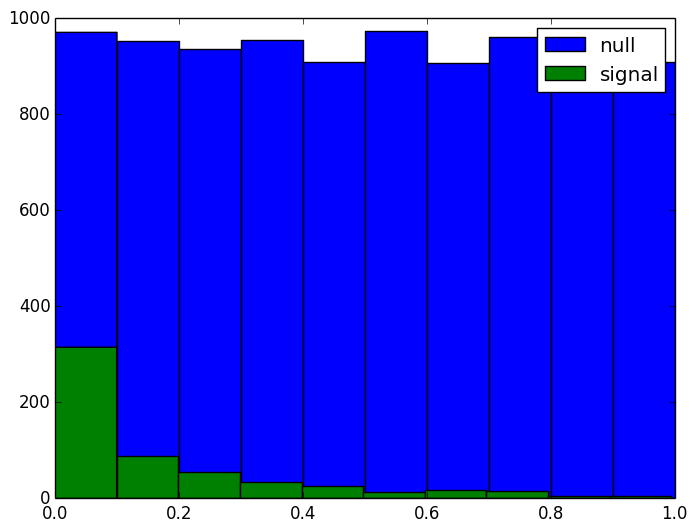

In [174]:
plt[:hist](data[find(labels.==1)], label = "null") #data associated with null cluster
plt[:hist](data[find(labels.!=1)], label = "signal") #data associated with signals 
legend();

Metropolis hastings to sample mixture proportions and beta. 

In [175]:
#given proposal returns the step that metropolis chooses
function getMetropolisStep(prop, curr, prior_dist, curr_dist, prop_dist, data)
    n = length(data)
    likelihood_current = loglikelihood(curr_dist, data);
    likelihood_prop = loglikelihood(prop_dist, data); 

    prior_current = log(pdf(prior_dist, curr));
    prior_prop = log(pdf(prior_dist, prop));

    p_curr = likelihood_current+prior_current;
    p_prop = likelihood_prop+prior_prop;

    p_accept = exp(p_prop-p_curr); 

    #flip a p-weighted coin to determine whether we accept the change
    if(rand() < p_accept)
        return prop; 
    end
    return curr; 
end


getMetropolisStep (generic function with 1 method)

In [ ]:
length(b_arr)

In [176]:
for(curr_label in 2:(num_clusters+1)) #first label is always null 
    for(i in 1:1000)
        prop_width = 0.1
        #proposed betas are random step away from each beta
        b_prop = rand(Normal(b_arr[curr_label], prop_width));
        while(b_prop < 1)  b_prop = rand(Normal(b_arr[curr_label], prop_width)); end;
        curr_dist = Beta(1/b_arr[curr_label], b_arr[curr_label]); 
        prop_dist = Beta(1/b_prop, b_prop); 
        cluster = data[find(labels .== curr_label)];
        b_arr[curr_label]  = getMetropolisStep(b_prop, b_arr[curr_label],Beta_priordist,curr_dist, prop_dist,cluster);
    end
end  
b_arr

16-element Array{Float64,1}:
 1.0    
 2.30303
 2.2927 
 3.01827
 2.1106 
 2.83361
 2.02221
 2.81158
 3.44739
 2.60013
 2.99223
 3.18373
 2.53322
 6.19135
 2.47068
 2.64267

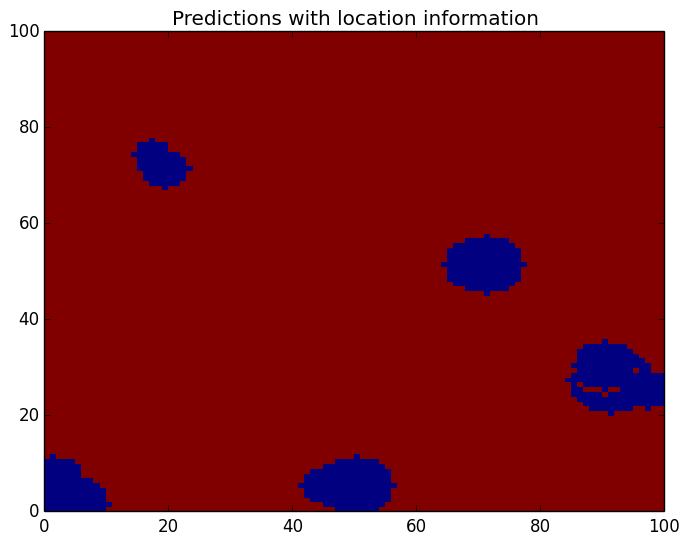

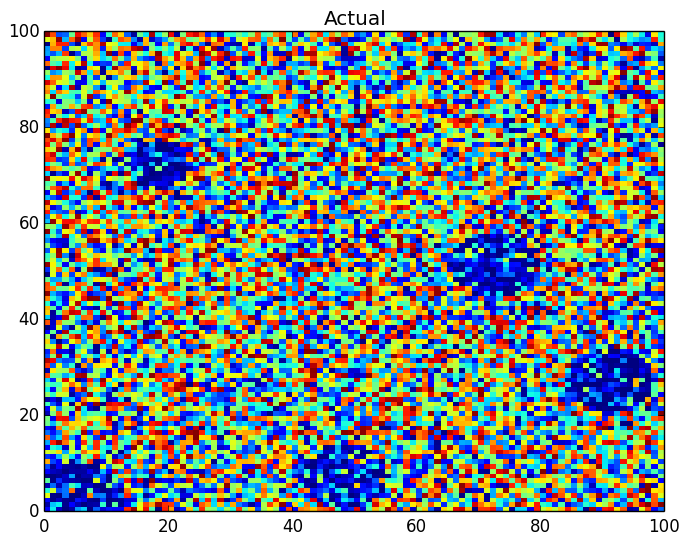

In [177]:
##plot predictions 
ddd = copy(data);
ddd[labels.==1] = 1; 
ddd[labels.!=1] = 0; 
dddd = reshape(ddd,n,n);
figure();
title("Predictions with location information");
pcolormesh(dddd);
figure();
title("Actual")
pcolormesh(dataSet);


In [150]:
num_clusters

16